# Using Darts predict battery SOH

## Import lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler

## Load dataset

In [2]:
files_name = '../data/merged_data.csv'
df = pd.read_csv(files_name)
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
df = df[['timestamp', 'SOH', 'SOC', 'c0', 'ah']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9086 entries, 0 to 9085
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  9086 non-null   datetime64[ns]
 1   SOH        9086 non-null   float64       
 2   SOC        9086 non-null   float64       
 3   c0         9086 non-null   float64       
 4   ah         9086 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 355.1 KB


In [3]:
series = TimeSeries.from_dataframe(df, 'timestamp', freq='1h')
series

<TimeSeries (DataArray) (timestamp: 9288, component: 4, sample: 1)> Size: 297kB
array([[[   983.26981346],
        [   604.62055556],
        [ 11594.76667   ],
        [184549.1503    ]],

       [[   983.25864853],
        [   601.47638889],
        [ 11594.76667   ],
        [184549.1503    ]],

       [[   983.24749151],
        [   603.02333333],
        [ 11594.76667   ],
        [184549.1503    ]],

       ...,

       [[   960.49013797],
        [   494.1       ],
        [ 19610.08333   ],
        [401389.8661    ]],

       [[   960.48929551],
        [   477.01694444],
        [ 19610.08333   ],
        [401389.8661    ]],

       [[   960.48845274],
        [   493.83333333],
        [ 19610.08333   ],
        [401389.8661    ]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 74kB 2023-06-09T16:00:00 ... 2024-0...
  * component  (component) object 32B 'SOH' 'SOC' 'c0' 'ah'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Filling 

In [4]:
from darts.utils.missing_values import fill_missing_values

fill_series = fill_missing_values(series)

In [5]:
series = fill_series
series

<TimeSeries (DataArray) (timestamp: 9288, component: 4, sample: 1)> Size: 297kB
array([[[   983.26981346],
        [   604.62055556],
        [ 11594.76667   ],
        [184549.1503    ]],

       [[   983.25864853],
        [   601.47638889],
        [ 11594.76667   ],
        [184549.1503    ]],

       [[   983.24749151],
        [   603.02333333],
        [ 11594.76667   ],
        [184549.1503    ]],

       ...,

       [[   960.49013797],
        [   494.1       ],
        [ 19610.08333   ],
        [401389.8661    ]],

       [[   960.48929551],
        [   477.01694444],
        [ 19610.08333   ],
        [401389.8661    ]],

       [[   960.48845274],
        [   493.83333333],
        [ 19610.08333   ],
        [401389.8661    ]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 74kB 2023-06-09T16:00:00 ... 2024-0...
  * component  (component) object 32B 'SOH' 'SOC' 'c0' 'ah'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Scaler

In [6]:
scaler = Scaler()
scaler_series = scaler.fit_transform(series)
scaler_series

<TimeSeries (DataArray) (timestamp: 9288, component: 4, sample: 1)> Size: 297kB
array([[[1.00000000e+00],
        [5.50552215e-01],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[9.99509909e-01],
        [5.46978082e-01],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[9.99020166e-01],
        [5.48736572e-01],
        [0.00000000e+00],
        [0.00000000e+00]],

       ...,

       [[7.39739056e-05],
        [4.24917917e-01],
        [1.00000000e+00],
        [1.00000000e+00]],

       [[3.69938336e-05],
        [4.05498745e-01],
        [1.00000000e+00],
        [1.00000000e+00]],

       [[0.00000000e+00],
        [4.24614784e-01],
        [1.00000000e+00],
        [1.00000000e+00]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 74kB 2023-06-09T16:00:00 ... 2024-0...
  * component  (component) object 32B 'SOH' 'SOC' 'c0' 'ah'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

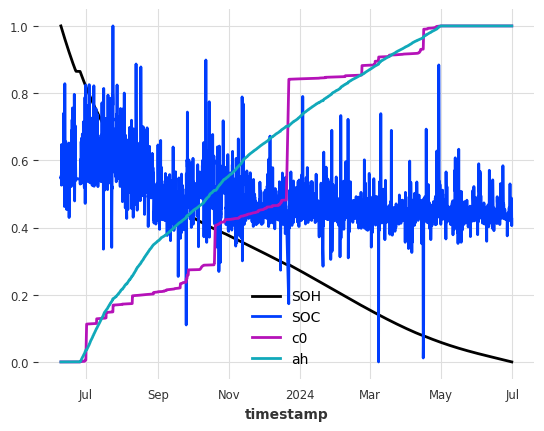

In [8]:
scaler_series.plot()
plt.show()

### Split data

In [22]:
train, test = scaler_series.split_before(0.8)

## Training data

In [49]:
from darts.models import RNNModel

model = RNNModel(
    input_chunk_length = 168,
    training_length = 168,
    model = 'LSTM',
    hidden_dim=64,
    n_rnn_layers=5,
    n_epochs=400,
    batch_size=1024,
)

In [50]:
model.fit(train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 151 K 
4 | V             | Linear           | 260   
---------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.605     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


RNNModel(model=LSTM, hidden_dim=64, n_rnn_layers=5, dropout=0.0, training_length=168, input_chunk_length=168, n_epochs=400, batch_size=1024)

## Predict

In [51]:
predictions = model.predict(n=len(test))
predictions

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (timestamp: 1859, component: 4, sample: 1)> Size: 59kB
array([[[0.0802506 ],
        [0.44230389],
        [0.93280214],
        [0.95742945]],

       [[0.08047762],
        [0.44226447],
        [0.93333694],
        [0.95783259]],

       [[0.08073373],
        [0.44422052],
        [0.933282  ],
        [0.95771239]],

       ...,

       [[0.29120508],
        [0.47367626],
        [0.83479248],
        [0.70220572]],

       [[0.29120508],
        [0.47367626],
        [0.83479248],
        [0.70220572]],

       [[0.29120508],
        [0.47367626],
        [0.83479248],
        [0.70220572]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 15kB 2024-04-14T05:00:00 ... 2024-0...
  * component  (component) object 32B 'SOH' 'SOC' 'c0' 'ah'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

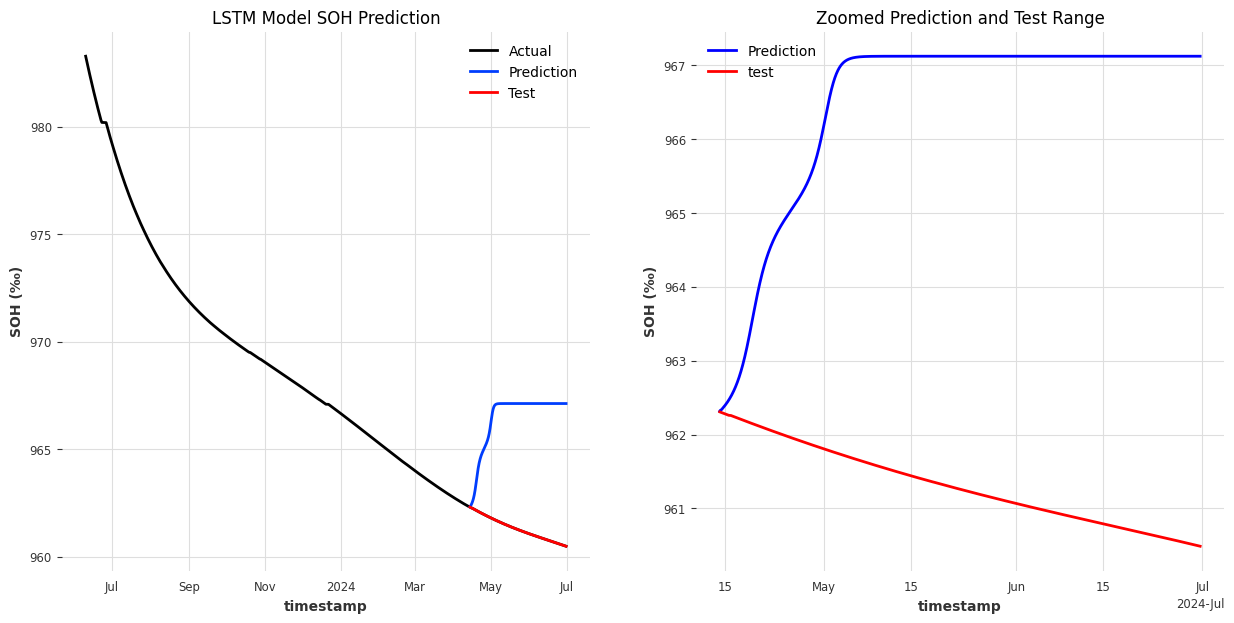

In [52]:
predictions_inverse = scaler.inverse_transform(predictions)
train_inverse = scaler.inverse_transform(train)
test_inverse = scaler.inverse_transform(test)


plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
series['SOH'].plot(label='Actual')
predictions_inverse['SOH'].plot(label='Prediction')
test_inverse['SOH'].plot(label = 'Test', color = 'red')

plt.title('LSTM Model SOH Prediction')
plt.ylabel('SOH (‰)')

plt.subplot(1, 2, 2)
predictions_inverse['SOH'].plot(label='Prediction', color='blue')
test_inverse['SOH'].plot(label = 'test', color = 'red')

plt.title('Zoomed Prediction and Test Range')
plt.ylabel('SOH (‰)')

plt.legend()
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

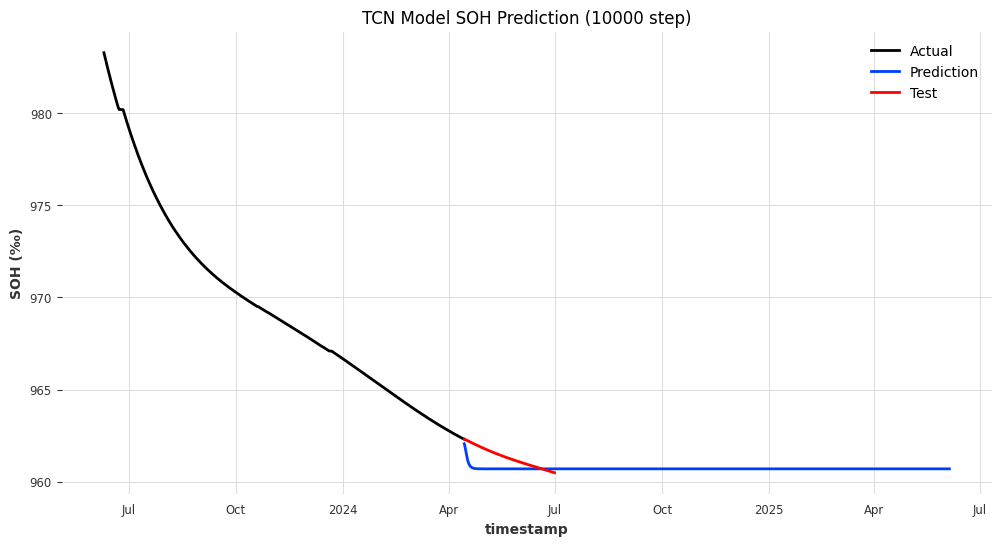

In [30]:
step = 10000
predictions = model.predict(n=step)
predictions_inverse = scaler.inverse_transform(predictions)

plt.figure(figsize=(12, 6))
train_inverse['SOH'].plot(label='Actual')
predictions_inverse['SOH'].plot(label='Prediction')
test_inverse['SOH'].plot(label = 'Test', color = 'red')

plt.title(f'LSTM Model SOH Prediction ({step} step)')
plt.ylabel('SOH (‰)')
plt.legend()
plt.show()

In [34]:
from darts.metrics import mae, rmse

predict = model.predict(n=len(test))

mae_value = mae(test, predict)
rmse_value = rmse(test, predict)

print(f"MAE: {mae_value}, RMSE: {rmse_value}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 0.033553757233069234, RMSE: 0.04166470934032338


In [34]:
model.save("../models/tcn_4k7y_0310.pt")

In [219]:
model_name = '../models/tcn_4k7y_0310.pt'
model = RNNModel.load(model_name)

### GRU

In [53]:
from darts.models import RNNModel

model = RNNModel(
    input_chunk_length = 168,
    training_length = 168,
    model = 'GRU',
    hidden_dim=64,
    n_rnn_layers=4,
    n_epochs=400,
    batch_size=1024,
)

In [54]:
model.fit(train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 88.3 K
4 | V             | Linear           | 260   
---------------------------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.354     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


RNNModel(model=GRU, hidden_dim=64, n_rnn_layers=4, dropout=0.0, training_length=168, input_chunk_length=168, n_epochs=400, batch_size=1024)

In [55]:
predictions = model.predict(n=len(test))
predictions

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (timestamp: 1859, component: 4, sample: 1)> Size: 59kB
array([[[0.07773487],
        [0.4450938 ],
        [0.92785754],
        [0.9587111 ]],

       [[0.07868581],
        [0.45045283],
        [0.92575529],
        [0.95769696]],

       [[0.07949187],
        [0.45501659],
        [0.92388124],
        [0.95719222]],

       ...,

       [[0.12334762],
        [0.46257181],
        [0.86666572],
        [0.91533794]],

       [[0.12334748],
        [0.462572  ],
        [0.86666574],
        [0.91533805]],

       [[0.12334735],
        [0.46257219],
        [0.86666576],
        [0.91533815]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 15kB 2024-04-14T05:00:00 ... 2024-0...
  * component  (component) object 32B 'SOH' 'SOC' 'c0' 'ah'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

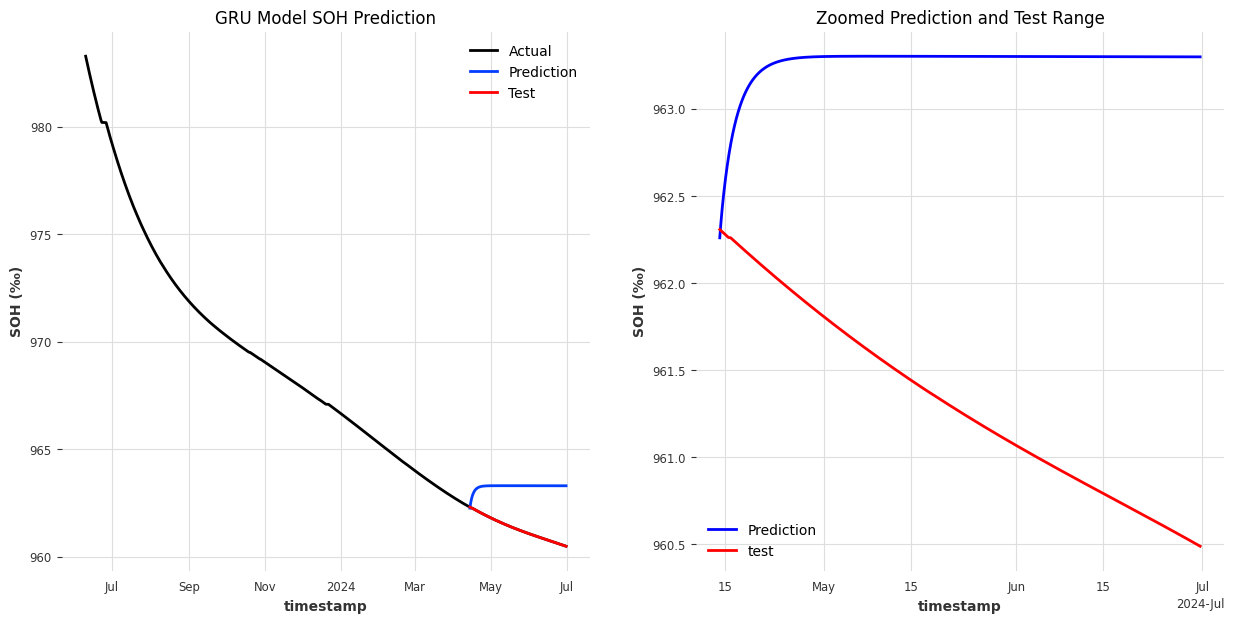

In [56]:
predictions_inverse = scaler.inverse_transform(predictions)
train_inverse = scaler.inverse_transform(train)
test_inverse = scaler.inverse_transform(test)


plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
series['SOH'].plot(label='Actual')
predictions_inverse['SOH'].plot(label='Prediction')
test_inverse['SOH'].plot(label = 'Test', color = 'red')

plt.title('GRU Model SOH Prediction')
plt.ylabel('SOH (‰)')

plt.subplot(1, 2, 2)
predictions_inverse['SOH'].plot(label='Prediction', color='blue')
test_inverse['SOH'].plot(label = 'test', color = 'red')

plt.title('Zoomed Prediction and Test Range')
plt.ylabel('SOH (‰)')

plt.legend()
plt.show()

In [57]:
from darts.metrics import mae, rmse

predict = model.predict(n=len(test))

mae_value = mae(test, predict)
rmse_value = rmse(test, predict)

print(f"MAE: {mae_value}, RMSE: {rmse_value}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAE: 0.08197241859260593, RMSE: 0.08834781383688577
